<a href="https://colab.research.google.com/github/ranjuadhikari14/Potato_Disease_Detection/blob/main/potato_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

dataset_path = kagglehub.dataset_download("mohitsingh1804/plantvillage")
print("Path to dataset files:", dataset_path)


Path to dataset files: /kaggle/input/plantvillage


In [2]:
!ls '/kaggle/input/plantvillage/PlantVillage/train'

 Apple___Apple_scab
 Apple___Black_rot
 Apple___Cedar_apple_rust
 Apple___healthy
 Blueberry___healthy
'Cherry_(including_sour)___healthy'
'Cherry_(including_sour)___Powdery_mildew'
'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
'Corn_(maize)___Common_rust_'
'Corn_(maize)___healthy'
'Corn_(maize)___Northern_Leaf_Blight'
 Grape___Black_rot
'Grape___Esca_(Black_Measles)'
 Grape___healthy
'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
'Orange___Haunglongbing_(Citrus_greening)'
 Peach___Bacterial_spot
 Peach___healthy
 Pepper,_bell___Bacterial_spot
 Pepper,_bell___healthy
 Potato___Early_blight
 Potato___healthy
 Potato___Late_blight
 Raspberry___healthy
 Soybean___healthy
 Squash___Powdery_mildew
 Strawberry___healthy
 Strawberry___Leaf_scorch
 Tomato___Bacterial_spot
 Tomato___Early_blight
 Tomato___healthy
 Tomato___Late_blight
 Tomato___Leaf_Mold
 Tomato___Septoria_leaf_spot
'Tomato___Spider_mites Two-spotted_spider_mite'
 Tomato___Target_Spot
 Tomato___Tomato_mosaic_virus
 Tomato_

In [3]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [4]:
path_train = '/kaggle/input/plantvillage/PlantVillage/train'
path_test = '/kaggle/input/plantvillage/PlantVillage/val'

In [5]:
train_files = glob.glob(path_train + '/Potato*/*')
test_files = glob.glob(path_test + '/Potato*/*')

In [6]:
def build_df(file_list):
    return pd.DataFrame({
        'filename': [os.path.relpath(f, start=path_train if 'train' in f else path_test) for f in file_list],
        'class': [os.path.basename(os.path.dirname(f)) for f in file_list]
    })

train_df = build_df(train_files)
test_df = build_df(test_files)

In [7]:
image_size = (128, 128)
batch_size = 32

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=path_train,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=path_train,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=path_test,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1377 validated image filenames belonging to 3 classes.
Found 344 validated image filenames belonging to 3 classes.
Found 431 validated image filenames belonging to 3 classes.


In [10]:
def flatten_generator(gen):
    X, y = [], []
    for batch_x, batch_y in gen:
        X.extend(batch_x.reshape(batch_x.shape[0], -1))
        y.extend(batch_y)
        if len(X) >= len(gen.filenames):
            break
    return np.array(X), np.array(y)

X_train_ann, y_train_ann = flatten_generator(train_generator)
X_val_ann, y_val_ann = flatten_generator(val_generator)
X_test_ann, y_test_ann = flatten_generator(test_generator)


In [11]:
num_classes = len(train_generator.class_indices)

In [12]:
ann_model = models.Sequential([
    layers.Input(shape=(X_train_ann.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
# Train ANN
ann_history = ann_model.fit(X_train_ann, y_train_ann, validation_data=(X_val_ann, y_val_ann), epochs=10)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.5013 - loss: 7.5897 - val_accuracy: 0.6483 - val_loss: 48.6160
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5842 - loss: 3.1367 - val_accuracy: 0.2035 - val_loss: 14.1681
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6687 - loss: 0.9255 - val_accuracy: 0.5785 - val_loss: 4.9166
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6726 - loss: 0.6051 - val_accuracy: 0.0436 - val_loss: 4.3009
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6913 - loss: 0.6412 - val_accuracy: 0.4244 - val_loss: 4.3041
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7033 - loss: 0.5402 - val_accuracy: 0.6134 - val_loss: 4.3993
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7267 - loss: 0.5372 - val_accuracy: 0.6192 - val_loss: 5.0886
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7019 - loss: 0.5436 - val_accuracy: 0.6453 - val

In [14]:
# Evaluate ANN
ann_loss, ann_acc = ann_model.evaluate(X_test_ann, y_test_ann)
print(f" ANN Test Accuracy: {ann_acc:.2f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3736 - loss: 1.6340
 ANN Test Accuracy: 0.61


In [15]:
#  CNN Model
cnn_model = models.Sequential([
    layers.Input(shape=(*image_size, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
#  Train CNN
cnn_history = cnn_model.fit(train_generator, validation_data=val_generator, epochs=10)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 345ms/step - accuracy: 0.5482 - loss: 0.7286 - val_accuracy: 0.4913 - val_loss: 6.2571
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.8398 - loss: 0.3500 - val_accuracy: 0.5872 - val_loss: 5.2384
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.8999 - loss: 0.2283 - val_accuracy: 0.6163 - val_loss: 6.9764
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - accuracy: 0.9249 - loss: 0.2073 - val_accuracy: 0.6250 - val_loss: 7.1888
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.9534 - loss: 0.1275 - val_accuracy: 0.6483 - val_loss: 5.9124
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.9631 - loss: 0.1040 - val_accuracy: 0.6453 - val_loss: 5.3866
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.9594 - loss: 0.0928 - val_accuracy: 0.6134 - val_loss: 5.8420
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.9548 - loss: 0.1249 - val_accur

In [17]:
#  Evaluate CNN
cnn_loss, cnn_acc = cnn_model.evaluate(test_generator)
print(f"CNN Test Accuracy: {cnn_acc:.2f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.5485 - loss: 3.5561
CNN Test Accuracy: 0.74


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


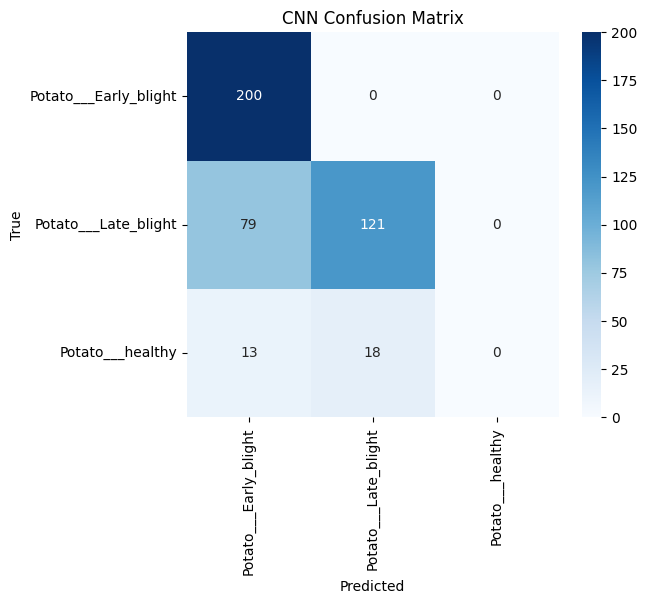

In [18]:
# STEP 14: Confusion Matrix (for CNN)
y_pred_cnn = cnn_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_cnn, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

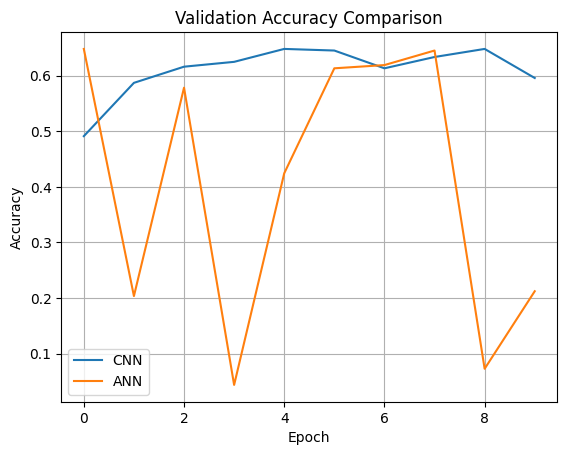

In [19]:
# STEP 15: Accuracy comparison plot
plt.plot(cnn_history.history['val_accuracy'], label='CNN')
plt.plot(ann_history.history['val_accuracy'], label='ANN')
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
#using dropout

In [24]:
from tensorflow.keras import models, layers

image_size = 128
num_classes = 3

cnn_model = models.Sequential([
    layers.Input(shape=(image_size, image_size, 3)),

    # 1st Conv Block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # 2nd Conv Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # 3rd Conv Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Fully Connected Layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # Output Layer
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [25]:
cnn_history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 342ms/step - accuracy: 0.5073 - loss: 0.9716 - val_accuracy: 0.1250 - val_loss: 2.0120
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step - accuracy: 0.6949 - loss: 0.5709 - val_accuracy: 0.5698 - val_loss: 3.0597
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 0.8641 - loss: 0.3227 - val_accuracy: 0.6076 - val_loss: 4.5354
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - accuracy: 0.9127 - loss: 0.2428 - val_accuracy: 0.6076 - val_loss: 4.6793
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.9359 - loss: 0.1897 - val_accuracy: 0.6424 - val_loss: 5.4547
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.8873 - loss: 0.2733 - val_accuracy: 0.4942 - val_loss: 2.1370
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.9164 - loss: 0.2110 - val_accuracy: 0.6192 - val_loss: 5.4399
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - accuracy: 0.9450 - loss: 0.1505 - val_accu

In [26]:
test_loss, test_acc = cnn_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.6625 - loss: 3.4055
Test Accuracy: 0.84
Test Loss: 1.26


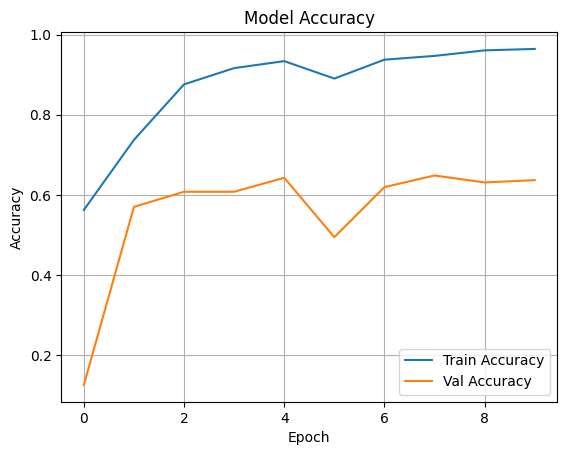

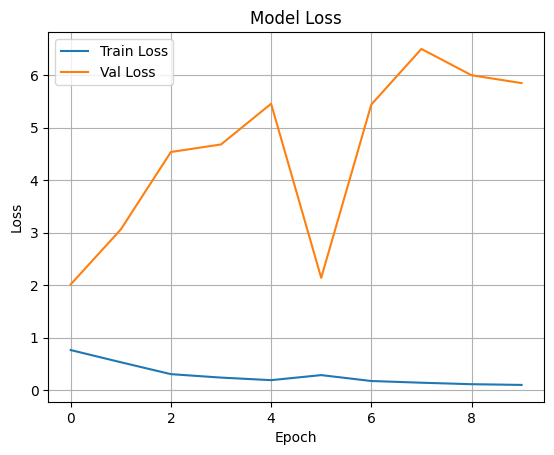

In [27]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step
                       precision    recall  f1-score   support

Potato___Early_blight       0.83      1.00      0.91       200
 Potato___Late_blight       0.85      0.81      0.83       200
     Potato___healthy       0.00      0.00      0.00        31

             accuracy                           0.84       431
            macro avg       0.56      0.60      0.58       431
         weighted avg       0.78      0.84      0.80       431



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


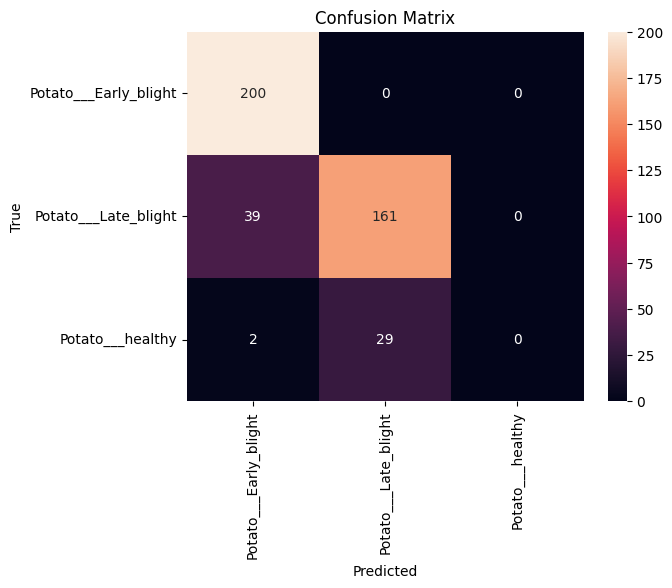

In [28]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get true labels and predictions
y_true = test_generator.classes
y_pred_probs = cnn_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
